##### 4层卷积，3层全连接
* batch_size:256
* learning_rate:1e-4
* 优化函数：RMSProp

In [1]:
# start tensorflow interactiveSession                 线上  0.686             
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random
import h5py

filename = 'E:/Alibaba German AI Challenge/data_process/data_shuffle.npy'

data = np.load(filename)

train = data[:49000]
vali = data[49000:]

print('The shape of train is ',train.shape)
print('The shape of vali is ',vali.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 18432])
y_ = tf.placeholder("float", [None, 17])
keep_prob = tf.placeholder("float")
x_image = tf.reshape(x, [-1, 32, 32, 18])

# first convolutinal layer
w_conv1_1 = weight_variable([3, 3, 18, 64])
b_conv1_1 = bias_variable([64])

w_conv1_2 = weight_variable([3, 3, 64, 64])
b_conv1_2 = bias_variable([64])

h_conv1_1 = tf.nn.relu(conv2d(x_image, w_conv1_1) + b_conv1_1)
h_conv1_2 = tf.nn.relu(conv2d(h_conv1_1, w_conv1_2) + b_conv1_2)
h_pool1 = max_pool_2x2(h_conv1_2)

# second convolutional layer
w_conv2_1 = weight_variable([3, 3, 64, 128])
b_conv2_1 = bias_variable([128])

w_conv2_2 = weight_variable([3, 3, 128, 128])
b_conv2_2 = bias_variable([128])

h_conv2_1 = tf.nn.relu(conv2d(h_pool1, w_conv2_1) + b_conv2_1)
h_conv2_2 = tf.nn.relu(conv2d(h_conv2_1, w_conv2_2) + b_conv2_2)
h_pool2 = max_pool_2x2(h_conv2_2)

# flatten
h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*128])

# densely connected layer
w_fc1 = weight_variable([8*8*128, 1024])
b_fc1 = bias_variable([1024])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# fc_2
w_fc2 = weight_variable([1024, 2048])
b_fc2 = bias_variable([2048])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# dropout
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

# readout layer
w_fc3 = weight_variable([2048, 17])
b_fc3 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc2_drop, w_fc3) + b_fc3)

# train and evaluate the model
#交叉熵作为损失函数
delta = 1e-7
learning_rate = 1e-4
#cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))+tf.norm(w_fc3)
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
train_step = tf.train.RMSPropOptimizer(learning_rate).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []
vali_Eval = []
train_Eval = []

batch_size = 256
step_num = 45000
for i in range(step_num):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})
    if i%200 == 0:
        temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        Loss.append(temp_loss)
        vali_Eval.append(vali_accuracy)
        train_Eval.append(train_accuracy)
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g" %(i, train_accuracy, vali_accuracy, temp_loss))



The shape of train is  (49000, 18449)
The shape of vali is  (1989, 18449)
step 0, train accuracy 0.0703125, vali accuracy 0.0563097, train loss 3812.73
step 200, train accuracy 0.15625, vali accuracy 0.159879, train loss 3481.51
step 400, train accuracy 0.199219, vali accuracy 0.196078, train loss 3304.21
step 600, train accuracy 0.203125, vali accuracy 0.211161, train loss 3288.09
step 800, train accuracy 0.234375, vali accuracy 0.22725, train loss 3146.52
step 1000, train accuracy 0.199219, vali accuracy 0.226244, train loss 3304.21
step 1200, train accuracy 0.269531, vali accuracy 0.22725, train loss 3010.81
step 1400, train accuracy 0.269531, vali accuracy 0.262443, train loss 3007.8
step 1600, train accuracy 0.21875, vali accuracy 0.25993, train loss 3216.9
step 1800, train accuracy 0.289062, vali accuracy 0.275515, train loss 2922.88
step 2000, train accuracy 0.289062, vali accuracy 0.279537, train loss 2905.58
step 2200, train accuracy 0.3125, vali accuracy 0.275515, train loss 

step 20600, train accuracy 0.890625, vali accuracy 0.726496, train loss 98.5811
step 20800, train accuracy 0.859375, vali accuracy 0.715435, train loss 104.951
step 21000, train accuracy 0.839844, vali accuracy 0.716943, train loss 125.559
step 21200, train accuracy 0.867188, vali accuracy 0.736048, train loss 97.8203
step 21400, train accuracy 0.867188, vali accuracy 0.714932, train loss 110.624
step 21600, train accuracy 0.878906, vali accuracy 0.729512, train loss 87.7533
step 21800, train accuracy 0.820312, vali accuracy 0.733534, train loss 120.069
step 22000, train accuracy 0.898438, vali accuracy 0.732529, train loss 92.187
step 22200, train accuracy 0.839844, vali accuracy 0.736048, train loss 113.097
step 22400, train accuracy 0.863281, vali accuracy 0.717949, train loss 100.211
step 22600, train accuracy 0.835938, vali accuracy 0.735546, train loss 112.445
step 22800, train accuracy 0.867188, vali accuracy 0.737054, train loss 118.925
step 23000, train accuracy 0.84375, vali 

step 41200, train accuracy 0.976562, vali accuracy 0.75264, train loss 24.1166
step 41400, train accuracy 0.992188, vali accuracy 0.750126, train loss 17.2171
step 41600, train accuracy 0.964844, vali accuracy 0.727501, train loss 36.2873
step 41800, train accuracy 0.945312, vali accuracy 0.729512, train loss 82.7673
step 42000, train accuracy 0.96875, vali accuracy 0.732529, train loss 31.939
step 42200, train accuracy 0.957031, vali accuracy 0.72901, train loss 41.0956
step 42400, train accuracy 0.964844, vali accuracy 0.738562, train loss 61.1998
step 42600, train accuracy 0.960938, vali accuracy 0.731523, train loss 32.0826
step 42800, train accuracy 0.964844, vali accuracy 0.748115, train loss 27.6233
step 43000, train accuracy 0.972656, vali accuracy 0.746104, train loss 40.1528
step 43200, train accuracy 0.980469, vali accuracy 0.739568, train loss 35.0948
step 43400, train accuracy 0.988281, vali accuracy 0.752137, train loss 29.6036
step 43600, train accuracy 0.960938, vali ac

##### 绘制训练过程中accuracy在训练集与验证集中的表现

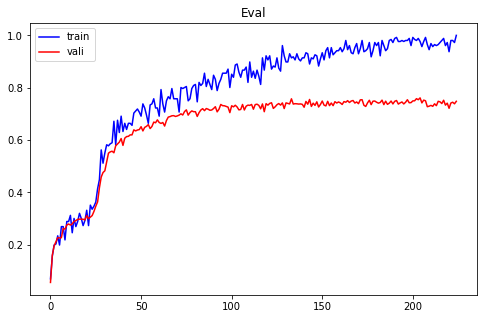

In [2]:
import matplotlib.pyplot as plt

xx = list(range(len(train_Eval)))

plt.figure(figsize = (8,5))
plt.plot(xx,train_Eval, color = 'blue', label = 'train')
plt.plot(xx,vali_Eval, color = 'red', label = 'vali')
plt.title('Eval')
plt.legend()
plt.show()

##### 分析模型分类能力

In [3]:
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.60      0.64      0.62       115
          1       0.63      0.45      0.52       107
          2       0.72      0.74      0.73       130
          3       0.56      0.61      0.58       118
          4       0.58      0.48      0.52       141
          5       0.63      0.71      0.67       122
          6       0.86      0.88      0.87       121
          7       0.75      0.70      0.73       136
          8       0.76      0.77      0.76       117
          9       0.51      0.54      0.53        97
         10       0.86      0.89      0.88       108
         11       0.75      0.75      0.75       100
         12       0.83      0.87      0.85       112
         13       0.84      0.77      0.80       114
         14       0.91      0.95      0.93       107
         15       0.85      0.93      0.89       138
         16       0.99      0.98      0.99       106

avg / total       0.74      0.74      0.74  

##### 绘制损失函数变化曲线

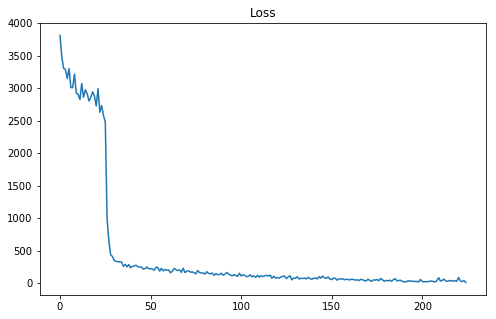

In [4]:
import matplotlib.pyplot as plt

xx = list(range(len(Loss)))

plt.figure(figsize = (8,5))
plt.plot(xx,Loss)
plt.title('Loss')
plt.show()

* batch_size:256
* learning_rate:1e-4
* 优化函数：Adam

In [1]:
# start tensorflow interactiveSession                            
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random
import h5py

filename = 'E:/Alibaba German AI Challenge/data_process/data_shuffle.npy'

data = np.load(filename)

train = data[:49000]
vali = data[49000:]

print('The shape of train is ',train.shape)
print('The shape of vali is ',vali.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 18432])
y_ = tf.placeholder("float", [None, 17])
keep_prob = tf.placeholder("float")
x_image = tf.reshape(x, [-1, 32, 32, 18])

# first convolutinal layer
w_conv1_1 = weight_variable([3, 3, 18, 64])
b_conv1_1 = bias_variable([64])

w_conv1_2 = weight_variable([3, 3, 64, 64])
b_conv1_2 = bias_variable([64])

h_conv1_1 = tf.nn.relu(conv2d(x_image, w_conv1_1) + b_conv1_1)
h_conv1_2 = tf.nn.relu(conv2d(h_conv1_1, w_conv1_2) + b_conv1_2)
h_pool1 = max_pool_2x2(h_conv1_2)

# second convolutional layer
w_conv2_1 = weight_variable([3, 3, 64, 128])
b_conv2_1 = bias_variable([128])

w_conv2_2 = weight_variable([3, 3, 128, 128])
b_conv2_2 = bias_variable([128])

h_conv2_1 = tf.nn.relu(conv2d(h_pool1, w_conv2_1) + b_conv2_1)
h_conv2_2 = tf.nn.relu(conv2d(h_conv2_1, w_conv2_2) + b_conv2_2)
h_pool2 = max_pool_2x2(h_conv2_2)

# flatten
h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*128])

# densely connected layer
w_fc1 = weight_variable([8*8*128, 1024])
b_fc1 = bias_variable([1024])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# fc_2
w_fc2 = weight_variable([1024, 2048])
b_fc2 = bias_variable([2048])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# dropout
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

# readout layer
w_fc3 = weight_variable([2048, 17])
b_fc3 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc2_drop, w_fc3) + b_fc3)

# train and evaluate the model
#交叉熵作为损失函数
delta = 1e-7
learning_rate = 1e-4
#cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))+tf.norm(w_fc3)
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []
vali_Eval = []
train_Eval = []

batch_size = 256
step_num = 45000
for i in range(step_num):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})
    if i%200 == 0:
        temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        Loss.append(temp_loss)
        vali_Eval.append(vali_accuracy)
        train_Eval.append(train_accuracy)
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g" %(i, train_accuracy, vali_accuracy, temp_loss))



The shape of train is  (49000, 18449)
The shape of vali is  (1989, 18449)
step 0, train accuracy 0.0585938, vali accuracy 0.0593263, train loss 3757.11
step 200, train accuracy 0.117188, vali accuracy 0.0925088, train loss 3642.84
step 400, train accuracy 0.132812, vali accuracy 0.113625, train loss 3578.22
step 600, train accuracy 0.078125, vali accuracy 0.128708, train loss 3791.56
step 800, train accuracy 0.0976562, vali accuracy 0.126697, train loss 3723.28
step 1000, train accuracy 0.109375, vali accuracy 0.116139, train loss 3674.88
step 1200, train accuracy 0.121094, vali accuracy 0.113122, train loss 3626.57
step 1400, train accuracy 0.0976562, vali accuracy 0.135747, train loss 3722.49
step 1600, train accuracy 0.136719, vali accuracy 0.151835, train loss 3562.1
step 1800, train accuracy 0.179688, vali accuracy 0.16541, train loss 3384.95
step 2000, train accuracy 0.125, vali accuracy 0.156863, train loss 3608.77
step 2200, train accuracy 0.171875, vali accuracy 0.169432, trai

step 20600, train accuracy 0.777344, vali accuracy 0.71091, train loss 157.165
step 20800, train accuracy 0.71875, vali accuracy 0.70186, train loss 194.445
step 21000, train accuracy 0.8125, vali accuracy 0.704374, train loss 145.519
step 21200, train accuracy 0.765625, vali accuracy 0.713424, train loss 168.212
step 21400, train accuracy 0.753906, vali accuracy 0.71091, train loss 166.803
step 21600, train accuracy 0.761719, vali accuracy 0.719457, train loss 164.872
step 21800, train accuracy 0.800781, vali accuracy 0.717949, train loss 152.703
step 22000, train accuracy 0.777344, vali accuracy 0.716943, train loss 173.225
step 22200, train accuracy 0.808594, vali accuracy 0.707391, train loss 140.487
step 22400, train accuracy 0.78125, vali accuracy 0.715435, train loss 178.268
step 22600, train accuracy 0.792969, vali accuracy 0.728507, train loss 140.218
step 22800, train accuracy 0.8125, vali accuracy 0.719457, train loss 152.018
step 23000, train accuracy 0.800781, vali accurac

step 41400, train accuracy 0.925781, vali accuracy 0.755656, train loss 65.8294
step 41600, train accuracy 0.894531, vali accuracy 0.757667, train loss 70.408
step 41800, train accuracy 0.914062, vali accuracy 0.758673, train loss 66.5516
step 42000, train accuracy 0.941406, vali accuracy 0.754651, train loss 59.2683
step 42200, train accuracy 0.886719, vali accuracy 0.75817, train loss 83.4837
step 42400, train accuracy 0.882812, vali accuracy 0.763198, train loss 77.8197
step 42600, train accuracy 0.902344, vali accuracy 0.757164, train loss 93.6495
step 42800, train accuracy 0.925781, vali accuracy 0.75264, train loss 55.1926
step 43000, train accuracy 0.902344, vali accuracy 0.745601, train loss 81.3459
step 43200, train accuracy 0.917969, vali accuracy 0.75817, train loss 55.7477
step 43400, train accuracy 0.953125, vali accuracy 0.75264, train loss 59.3887
step 43600, train accuracy 0.945312, vali accuracy 0.748115, train loss 52.0279
step 43800, train accuracy 0.933594, vali acc

In [5]:
step_num = 10000
for i in range(step_num):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})
    if i%200 == 0:
        temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        Loss.append(temp_loss)
        vali_Eval.append(vali_accuracy)
        train_Eval.append(train_accuracy)
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g" %(i, train_accuracy, vali_accuracy, temp_loss))

step 0, train accuracy 0.925781, vali accuracy 0.754651, train loss 56.5963
step 200, train accuracy 0.941406, vali accuracy 0.750628, train loss 50.2184
step 400, train accuracy 0.953125, vali accuracy 0.761187, train loss 48.3685
step 600, train accuracy 0.964844, vali accuracy 0.761187, train loss 45.9842
step 800, train accuracy 0.886719, vali accuracy 0.751634, train loss 67.7832
step 1000, train accuracy 0.953125, vali accuracy 0.757164, train loss 42.6591
step 1200, train accuracy 0.921875, vali accuracy 0.751131, train loss 56.2769
step 1400, train accuracy 0.9375, vali accuracy 0.750628, train loss 49.6129
step 1600, train accuracy 0.9375, vali accuracy 0.750628, train loss 59.3849
step 1800, train accuracy 0.953125, vali accuracy 0.751131, train loss 52.3454
step 2000, train accuracy 0.925781, vali accuracy 0.753645, train loss 58.981
step 2200, train accuracy 0.945312, vali accuracy 0.757667, train loss 50.3053
step 2400, train accuracy 0.957031, vali accuracy 0.757164, trai

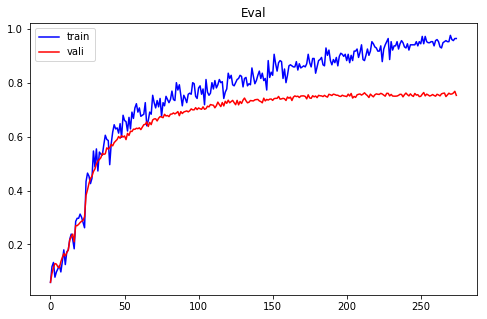

In [6]:
import matplotlib.pyplot as plt

xx = list(range(len(train_Eval)))

plt.figure(figsize = (8,5))
plt.plot(xx,train_Eval, color = 'blue', label = 'train')
plt.plot(xx,vali_Eval, color = 'red', label = 'vali')
plt.title('Eval')
plt.legend()
plt.show()

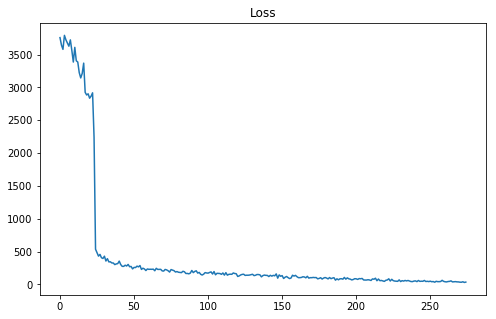

In [7]:
import matplotlib.pyplot as plt

xx = list(range(len(Loss)))

plt.figure(figsize = (8,5))
plt.plot(xx,Loss)
plt.title('Loss')
plt.show()

In [8]:
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.64      0.63      0.63       115
          1       0.61      0.62      0.61       107
          2       0.72      0.78      0.75       130
          3       0.55      0.62      0.58       118
          4       0.57      0.49      0.53       141
          5       0.68      0.68      0.68       122
          6       0.86      0.93      0.90       121
          7       0.73      0.71      0.72       136
          8       0.80      0.72      0.76       117
          9       0.48      0.49      0.48        97
         10       0.91      0.88      0.90       108
         11       0.72      0.81      0.76       100
         12       0.89      0.83      0.86       112
         13       0.84      0.85      0.85       114
         14       0.92      0.93      0.93       107
         15       0.93      0.91      0.92       138
         16       0.98      0.97      0.98       106

avg / total       0.76      0.75      0.75  

##### 利用CNN模型预测测试机样本label

In [9]:
import h5py
filename = 'E:/Alibaba German AI Challenge/origin_DATA/round1_test_a_20181109.h5'
f = h5py.File(filename,'r')
test_s1 = f['sen1']
test_s2 = f['sen2']

test = []
for i in range(0,test_s1.shape[0]):
    temp1 = test_s1[i].flatten()
    temp2 = test_s2[i].flatten()
    temp = np.hstack((temp1,temp2))
    test.append(temp)
test = np.array(test)

test_y = np.zeros((test.shape[0],17))

pred = tf.argmax(y_conv, 1)

test_x_0 = test[0:1500]
test_y_0 = test_y[0:1500]
P_0 = pred.eval(feed_dict={x:test_x_0, y_:test_y_0, keep_prob:1.0})

test_x_1 = test[1500:3000]
test_y_1 = test_y[1500:3000]
P_1 = pred.eval(feed_dict={x:test_x_1, y_:test_y_1, keep_prob:1.0})

test_x_2 = test[3000:4500]
test_y_2 = test_y[3000:4500]
P_2 = pred.eval(feed_dict={x:test_x_2, y_:test_y_2, keep_prob:1.0})

test_x_3 = test[4500:]
test_y_3 = test_y[4500:]
P_3 = pred.eval(feed_dict={x:test_x_3, y_:test_y_3, keep_prob:1.0})

P = np.hstack([P_0,P_1,P_2,P_3])

one_hot=tf.one_hot(P,17)
Pred_one_hot = sess.run(one_hot)
Pred_one_hot = Pred_one_hot.astype(np.int32)
out = pd.DataFrame(Pred_one_hot, columns = list(range(17)))
print(out.head())

outname = '256_batchsize_4_conv_3_fc_Adam.csv'
out.to_csv(outname, index = False, header = False)

   0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1
1   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
2   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0
3   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0
4   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0


* batch_size:1024
* learning_rate:1e-4
* 优化函数：Adam
* 激活函数：tanh

In [1]:
# start tensorflow interactiveSession                            线上      0.724
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random
import h5py

filename = 'E:/Alibaba German AI Challenge/data_process/data_shuffle.npy'

data = np.load(filename)

train = data[:49000]
vali = data[49000:]

print('The shape of train is ',train.shape)
print('The shape of vali is ',vali.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 18432])
y_ = tf.placeholder("float", [None, 17])
keep_prob = tf.placeholder("float")
x_image = tf.reshape(x, [-1, 32, 32, 18])

# first convolutinal layer
w_conv1_1 = weight_variable([3, 3, 18, 64])
b_conv1_1 = bias_variable([64])

w_conv1_2 = weight_variable([3, 3, 64, 64])
b_conv1_2 = bias_variable([64])

h_conv1_1 = tf.nn.tanh(conv2d(x_image, w_conv1_1) + b_conv1_1)
h_conv1_2 = tf.nn.tanh(conv2d(h_conv1_1, w_conv1_2) + b_conv1_2)
h_pool1 = max_pool_2x2(h_conv1_2)

# second convolutional layer
w_conv2_1 = weight_variable([3, 3, 64, 128])
b_conv2_1 = bias_variable([128])

w_conv2_2 = weight_variable([3, 3, 128, 128])
b_conv2_2 = bias_variable([128])

h_conv2_1 = tf.nn.tanh(conv2d(h_pool1, w_conv2_1) + b_conv2_1)
h_conv2_2 = tf.nn.tanh(conv2d(h_conv2_1, w_conv2_2) + b_conv2_2)
h_pool2 = max_pool_2x2(h_conv2_2)

# flatten
h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*128])

# densely connected layer
w_fc1 = weight_variable([8*8*128, 1024])
b_fc1 = bias_variable([1024])

h_fc1 = tf.nn.tanh(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# fc_2
w_fc2 = weight_variable([1024, 2048])
b_fc2 = bias_variable([2048])

h_fc2 = tf.nn.tanh(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# dropout
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

# readout layer
w_fc3 = weight_variable([2048, 17])
b_fc3 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc2_drop, w_fc3) + b_fc3)

# train and evaluate the model
#交叉熵作为损失函数
delta = 1e-7
learning_rate = 1e-4
#cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))+tf.norm(w_fc3)
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []
vali_Eval = []
train_Eval = []

batch_size = 256
step_num = 45000
for i in range(step_num):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})
    if i%200 == 0:
        temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        Loss.append(temp_loss)
        vali_Eval.append(vali_accuracy)
        train_Eval.append(train_accuracy)
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g" %(i, train_accuracy, vali_accuracy, temp_loss))



The shape of train is  (49000, 18449)
The shape of vali is  (1989, 18449)
step 0, train accuracy 0.125, vali accuracy 0.0759175, train loss 1228.64
step 200, train accuracy 0.414062, vali accuracy 0.397687, train loss 622.194
step 400, train accuracy 0.355469, vali accuracy 0.433886, train loss 794.264
step 600, train accuracy 0.4375, vali accuracy 0.447964, train loss 699.625
step 800, train accuracy 0.4375, vali accuracy 0.458522, train loss 732.963
step 1000, train accuracy 0.480469, vali accuracy 0.482655, train loss 614.008
step 1200, train accuracy 0.527344, vali accuracy 0.482152, train loss 665.741
step 1400, train accuracy 0.523438, vali accuracy 0.507793, train loss 557.104
step 1600, train accuracy 0.558594, vali accuracy 0.510809, train loss 595.273
step 1800, train accuracy 0.527344, vali accuracy 0.518854, train loss 553.715
step 2000, train accuracy 0.476562, vali accuracy 0.517345, train loss 653.942
step 2200, train accuracy 0.570312, vali accuracy 0.515837, train loss

step 20600, train accuracy 0.898438, vali accuracy 0.754651, train loss 84.7673
step 20800, train accuracy 0.917969, vali accuracy 0.759678, train loss 53.2892
step 21000, train accuracy 0.914062, vali accuracy 0.762192, train loss 78.4562
step 21200, train accuracy 0.914062, vali accuracy 0.769231, train loss 58.0513
step 21400, train accuracy 0.925781, vali accuracy 0.756159, train loss 55.3906
step 21600, train accuracy 0.917969, vali accuracy 0.762695, train loss 47.0431
step 21800, train accuracy 0.929688, vali accuracy 0.76722, train loss 47.032
step 22000, train accuracy 0.925781, vali accuracy 0.757667, train loss 55.8001
step 22200, train accuracy 0.949219, vali accuracy 0.7637, train loss 40.0382
step 22400, train accuracy 0.949219, vali accuracy 0.768728, train loss 36.8134
step 22600, train accuracy 0.933594, vali accuracy 0.769231, train loss 46.1251
step 22800, train accuracy 0.960938, vali accuracy 0.762192, train loss 25.5786
step 23000, train accuracy 0.953125, vali ac

KeyboardInterrupt: 

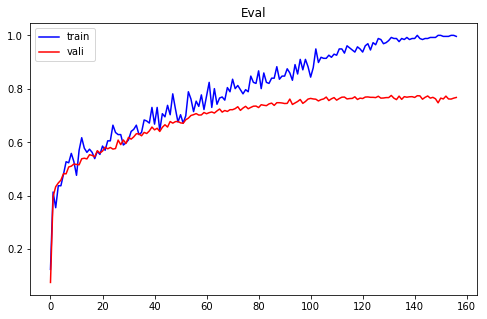

In [2]:
import matplotlib.pyplot as plt

xx = list(range(len(train_Eval)))

plt.figure(figsize = (8,5))
plt.plot(xx,train_Eval, color = 'blue', label = 'train')
plt.plot(xx,vali_Eval, color = 'red', label = 'vali')
plt.title('Eval')
plt.legend()
plt.show()

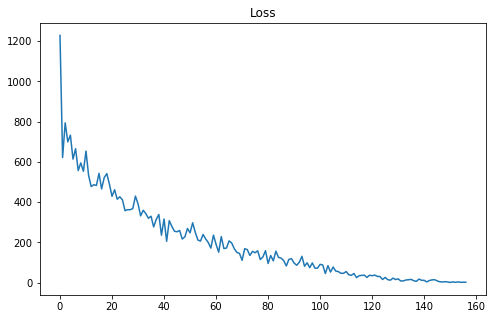

In [3]:
import matplotlib.pyplot as plt

xx = list(range(len(Loss)))

plt.figure(figsize = (8,5))
plt.plot(xx,Loss)
plt.title('Loss')
plt.show()

In [4]:
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.75      0.63      0.68       115
          1       0.63      0.62      0.63       107
          2       0.71      0.72      0.71       130
          3       0.62      0.63      0.62       118
          4       0.53      0.55      0.54       141
          5       0.67      0.67      0.67       122
          6       0.83      0.92      0.87       121
          7       0.75      0.76      0.75       136
          8       0.79      0.78      0.78       117
          9       0.58      0.59      0.58        97
         10       0.88      0.94      0.91       108
         11       0.75      0.79      0.77       100
         12       0.89      0.79      0.84       112
         13       0.83      0.83      0.83       114
         14       0.93      0.94      0.94       107
         15       0.89      0.86      0.88       138
         16       0.99      0.99      0.99       106

avg / total       0.76      0.76      0.76  

In [5]:
import h5py
filename = 'E:/Alibaba German AI Challenge/origin_DATA/round1_test_a_20181109.h5'
f = h5py.File(filename,'r')
test_s1 = f['sen1']
test_s2 = f['sen2']

test = []
for i in range(0,test_s1.shape[0]):
    temp1 = test_s1[i].flatten()
    temp2 = test_s2[i].flatten()
    temp = np.hstack((temp1,temp2))
    test.append(temp)
test = np.array(test)

test_y = np.zeros((test.shape[0],17))

pred = tf.argmax(y_conv, 1)

test_x_0 = test[0:1500]
test_y_0 = test_y[0:1500]
P_0 = pred.eval(feed_dict={x:test_x_0, y_:test_y_0, keep_prob:1.0})

test_x_1 = test[1500:3000]
test_y_1 = test_y[1500:3000]
P_1 = pred.eval(feed_dict={x:test_x_1, y_:test_y_1, keep_prob:1.0})

test_x_2 = test[3000:4500]
test_y_2 = test_y[3000:4500]
P_2 = pred.eval(feed_dict={x:test_x_2, y_:test_y_2, keep_prob:1.0})

test_x_3 = test[4500:]
test_y_3 = test_y[4500:]
P_3 = pred.eval(feed_dict={x:test_x_3, y_:test_y_3, keep_prob:1.0})

P = np.hstack([P_0,P_1,P_2,P_3])

one_hot=tf.one_hot(P,17)
Pred_one_hot = sess.run(one_hot)
Pred_one_hot = Pred_one_hot.astype(np.int32)
out = pd.DataFrame(Pred_one_hot, columns = list(range(17)))
print(out.head())

outname = '1024_batchsize_4_conv_3_fc_Adam_tanh.csv'
out.to_csv(outname, index = False, header = False)

   0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1
1   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0
2   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0
3   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0
4   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0


* batch_size:1024
* learning_rate:1e-4
* 优化函数：Adam
* 激活函数：relu
* 只使用s2的10个信道

In [1]:
# start tensorflow interactiveSession                   线上  0.734    
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random
import h5py

filename = 'E:/Alibaba German AI Challenge/data_process/data_shuffle.npy'

data = np.load(filename)

train = data[:49000, 8192:]
vali = data[49000:, 8192:]

print('The shape of train is ',train.shape)
print('The shape of vali is ',vali.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 10240])
y_ = tf.placeholder("float", [None, 17])
keep_prob = tf.placeholder("float")
x_image = tf.reshape(x, [-1, 32, 32, 10])

# first convolutinal layer
w_conv1_1 = weight_variable([3, 3, 10, 64])
b_conv1_1 = bias_variable([64])

w_conv1_2 = weight_variable([3, 3, 64, 64])
b_conv1_2 = bias_variable([64])

h_conv1_1 = tf.nn.relu(conv2d(x_image, w_conv1_1) + b_conv1_1)
h_conv1_2 = tf.nn.relu(conv2d(h_conv1_1, w_conv1_2) + b_conv1_2)
h_pool1 = max_pool_2x2(h_conv1_2)

# second convolutional layer
w_conv2_1 = weight_variable([3, 3, 64, 128])
b_conv2_1 = bias_variable([128])

w_conv2_2 = weight_variable([3, 3, 128, 128])
b_conv2_2 = bias_variable([128])

h_conv2_1 = tf.nn.relu(conv2d(h_pool1, w_conv2_1) + b_conv2_1)
h_conv2_2 = tf.nn.relu(conv2d(h_conv2_1, w_conv2_2) + b_conv2_2)
h_pool2 = max_pool_2x2(h_conv2_2)

# flatten
h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*128])

# densely connected layer
w_fc1 = weight_variable([8*8*128, 1024])
b_fc1 = bias_variable([1024])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# fc_2
w_fc2 = weight_variable([1024, 2048])
b_fc2 = bias_variable([2048])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# dropout
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

# readout layer
w_fc3 = weight_variable([2048, 17])
b_fc3 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc2_drop, w_fc3) + b_fc3)

# train and evaluate the model
#交叉熵作为损失函数
delta = 1e-7
learning_rate = 1e-4
#cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))+tf.norm(w_fc3)
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []
vali_Eval = []
train_Eval = []

batch_size = 1024
step_num = 45000
for i in range(step_num):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})
    if i%200 == 0:
        temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        Loss.append(temp_loss)
        vali_Eval.append(vali_accuracy)
        train_Eval.append(train_accuracy)
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g" %(i, train_accuracy, vali_accuracy, temp_loss))



The shape of train is  (49000, 10257)
The shape of vali is  (1989, 10257)
step 0, train accuracy 0.0585938, vali accuracy 0.0693816, train loss 14556.2
step 200, train accuracy 0.319336, vali accuracy 0.315737, train loss 10469.7
step 400, train accuracy 0.483398, vali accuracy 0.477627, train loss 1588.81
step 600, train accuracy 0.550781, vali accuracy 0.555556, train loss 1364.76
step 800, train accuracy 0.642578, vali accuracy 0.584213, train loss 1080.63
step 1000, train accuracy 0.631836, vali accuracy 0.612871, train loss 1064.39
step 1200, train accuracy 0.665039, vali accuracy 0.634992, train loss 1016.42
step 1400, train accuracy 0.6875, vali accuracy 0.646556, train loss 931.731
step 1600, train accuracy 0.729492, vali accuracy 0.679236, train loss 815.018
step 1800, train accuracy 0.737305, vali accuracy 0.683761, train loss 762.086
step 2000, train accuracy 0.749023, vali accuracy 0.709402, train loss 741.778
step 2200, train accuracy 0.764648, vali accuracy 0.722976, trai

KeyboardInterrupt: 

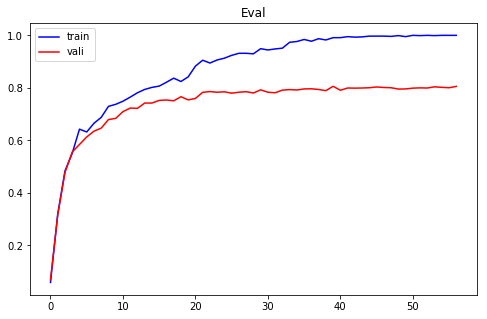

In [2]:
import matplotlib.pyplot as plt

xx = list(range(len(train_Eval)))

plt.figure(figsize = (8,5))
plt.plot(xx,train_Eval, color = 'blue', label = 'train')
plt.plot(xx,vali_Eval, color = 'red', label = 'vali')
plt.title('Eval')
plt.legend()
plt.show()

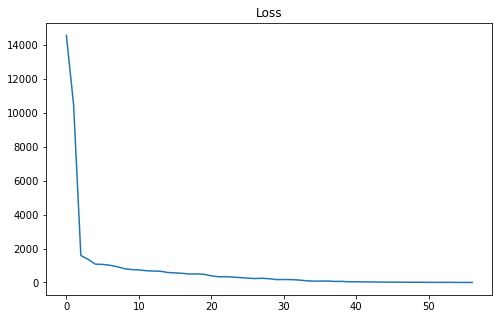

In [3]:
import matplotlib.pyplot as plt

xx = list(range(len(Loss)))

plt.figure(figsize = (8,5))
plt.plot(xx,Loss)
plt.title('Loss')
plt.show()

In [4]:
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.70      0.70      0.70       115
          1       0.60      0.73      0.66       107
          2       0.77      0.68      0.72       130
          3       0.69      0.71      0.70       118
          4       0.59      0.59      0.59       141
          5       0.70      0.73      0.71       122
          6       0.91      0.92      0.91       121
          7       0.79      0.76      0.77       136
          8       0.85      0.84      0.84       117
          9       0.59      0.57      0.58        97
         10       0.95      0.94      0.94       108
         11       0.83      0.89      0.86       100
         12       0.92      0.80      0.86       112
         13       0.91      0.88      0.89       114
         14       0.95      0.98      0.96       107
         15       0.92      0.94      0.93       138
         16       1.00      1.00      1.00       106

avg / total       0.80      0.80      0.80  

In [6]:
import h5py
filename = 'E:/Alibaba German AI Challenge/origin_DATA/round1_test_a_20181109.h5'
f = h5py.File(filename,'r')
test_s2 = f['sen2']

test = []
for i in range(0,test_s2.shape[0]):
    temp2 = test_s2[i].flatten()
    test.append(temp2)
test = np.array(test)

test_y = np.zeros((test.shape[0],17))

pred = tf.argmax(y_conv, 1)

test_x_0 = test[0:1500]
test_y_0 = test_y[0:1500]
P_0 = pred.eval(feed_dict={x:test_x_0, y_:test_y_0, keep_prob:1.0})

test_x_1 = test[1500:3000]
test_y_1 = test_y[1500:3000]
P_1 = pred.eval(feed_dict={x:test_x_1, y_:test_y_1, keep_prob:1.0})

test_x_2 = test[3000:4500]
test_y_2 = test_y[3000:4500]
P_2 = pred.eval(feed_dict={x:test_x_2, y_:test_y_2, keep_prob:1.0})

test_x_3 = test[4500:]
test_y_3 = test_y[4500:]
P_3 = pred.eval(feed_dict={x:test_x_3, y_:test_y_3, keep_prob:1.0})

P = np.hstack([P_0,P_1,P_2,P_3])

one_hot=tf.one_hot(P,17)
Pred_one_hot = sess.run(one_hot)
Pred_one_hot = Pred_one_hot.astype(np.int32)
out = pd.DataFrame(Pred_one_hot, columns = list(range(17)))
print(out.head())

outname = '1024_batchsize_4_conv_3_fc_Adam_relu_10signal.csv'
out.to_csv(outname, index = False, header = False)

   0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1
1   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0
2   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0
3   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0
4   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0


* batch_size:1024
* learning_rate:1e-4
* 优化函数：Adam
* 激活函数：relu
* 只使用s2的10个信道
* 对每个batch做标准化处理

In [1]:
# start tensorflow interactiveSession                       
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random
import h5py
from sklearn import preprocessing

filename = 'E:/Alibaba German AI Challenge/data_process/data_shuffle.npy'

data = np.load(filename)

train = data[:49000, 8192:]
vali = data[49000:, 8192:]

# 对验证数据的特征部分进行标准化
vali_x = preprocessing.scale(vali[:,:-17],1)
vali_y = vali[:,-17:]
vali = np.hstack([vali_x,vali_y])

print('The shape of train is ',train.shape)
print('The shape of vali is ',vali.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 10240])
y_ = tf.placeholder("float", [None, 17])
keep_prob = tf.placeholder("float")
x_image = tf.reshape(x, [-1, 32, 32, 10])

# first convolutinal layer
w_conv1_1 = weight_variable([3, 3, 10, 64])
b_conv1_1 = bias_variable([64])

w_conv1_2 = weight_variable([3, 3, 64, 64])
b_conv1_2 = bias_variable([64])

h_conv1_1 = tf.nn.relu(conv2d(x_image, w_conv1_1) + b_conv1_1)
h_conv1_2 = tf.nn.relu(conv2d(h_conv1_1, w_conv1_2) + b_conv1_2)
h_pool1 = max_pool_2x2(h_conv1_2)

# second convolutional layer
w_conv2_1 = weight_variable([3, 3, 64, 128])
b_conv2_1 = bias_variable([128])

w_conv2_2 = weight_variable([3, 3, 128, 128])
b_conv2_2 = bias_variable([128])

h_conv2_1 = tf.nn.relu(conv2d(h_pool1, w_conv2_1) + b_conv2_1)
h_conv2_2 = tf.nn.relu(conv2d(h_conv2_1, w_conv2_2) + b_conv2_2)
h_pool2 = max_pool_2x2(h_conv2_2)

# flatten
h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*128])

# densely connected layer
w_fc1 = weight_variable([8*8*128, 1024])
b_fc1 = bias_variable([1024])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# fc_2
w_fc2 = weight_variable([1024, 2048])
b_fc2 = bias_variable([2048])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# dropout
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

# readout layer
w_fc3 = weight_variable([2048, 17])
b_fc3 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc2_drop, w_fc3) + b_fc3)

# train and evaluate the model
#交叉熵作为损失函数
delta = 1e-7
learning_rate = 1e-4
#cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))+tf.norm(w_fc3)
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []
vali_Eval = []
train_Eval = []

batch_size = 1024
step_num = 45000
for i in range(step_num):
    batch_x,batch_y = get_batch(train,batch_size)
    batch_x = preprocessing.scale(batch_x,1)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})
    if i%200 == 0:
        temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        Loss.append(temp_loss)
        vali_Eval.append(vali_accuracy)
        train_Eval.append(train_accuracy)
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g" %(i, train_accuracy, vali_accuracy, temp_loss))



The shape of train is  (49000, 10257)
The shape of vali is  (1989, 10257)
step 0, train accuracy 0.0595703, vali accuracy 0.0603318, train loss 15468.7
step 200, train accuracy 0.1875, vali accuracy 0.15636, train loss 13410.3
step 400, train accuracy 0.197266, vali accuracy 0.171443, train loss 13240.2
step 600, train accuracy 0.167969, vali accuracy 0.17446, train loss 13732
step 800, train accuracy 0.191406, vali accuracy 0.175968, train loss 13338.9
step 1000, train accuracy 0.174805, vali accuracy 0.191554, train loss 13608.8
step 1200, train accuracy 0.202148, vali accuracy 0.185018, train loss 13160.2
step 1400, train accuracy 0.237305, vali accuracy 0.225239, train loss 12588.2
step 1600, train accuracy 0.225586, vali accuracy 0.227753, train loss 12777.6
step 1800, train accuracy 0.225586, vali accuracy 0.233283, train loss 12775.4
step 2000, train accuracy 0.222656, vali accuracy 0.239316, train loss 12830.5
step 2200, train accuracy 0.242188, vali accuracy 0.240322, train lo

KeyboardInterrupt: 

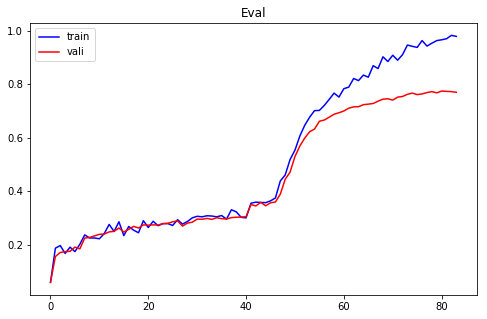

In [2]:
import matplotlib.pyplot as plt

xx = list(range(len(train_Eval)))

plt.figure(figsize = (8,5))
plt.plot(xx,train_Eval, color = 'blue', label = 'train')
plt.plot(xx,vali_Eval, color = 'red', label = 'vali')
plt.title('Eval')
plt.legend()
plt.show()

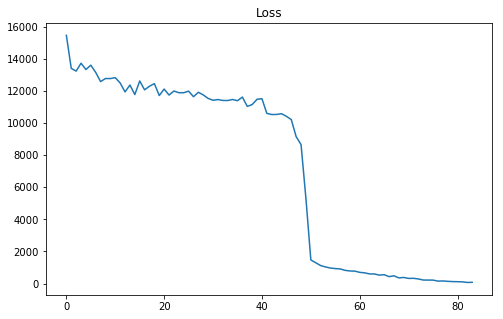

In [3]:
import matplotlib.pyplot as plt

xx = list(range(len(Loss)))

plt.figure(figsize = (8,5))
plt.plot(xx,Loss)
plt.title('Loss')
plt.show()

In [4]:
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.81      0.77      0.79       115
          1       0.69      0.71      0.70       107
          2       0.73      0.81      0.77       130
          3       0.76      0.78      0.77       118
          4       0.60      0.52      0.56       141
          5       0.66      0.59      0.62       122
          6       0.88      0.92      0.90       121
          7       0.76      0.85      0.80       136
          8       0.74      0.73      0.73       117
          9       0.65      0.62      0.63        97
         10       0.88      0.93      0.90       108
         11       0.62      0.69      0.65       100
         12       0.85      0.78      0.81       112
         13       0.84      0.82      0.83       114
         14       0.84      0.84      0.84       107
         15       0.89      0.86      0.87       138
         16       0.96      0.99      0.98       106

avg / total       0.77      0.77      0.77  

* 使用shuffle全部数据作为训练集，在train.h5中随机抽取5k样本做validation
* batch_size:1024
* learning_rate:1e-4
* 优化函数：Adam
* 激活函数：relu
* 只使用s2的10个信道
* 在损失函数中加入L2正则化项,正则化项系数设为1e-2

In [1]:
# start tensorflow interactiveSession                              线上    0.748
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random
import h5py

filename = 'E:/Alibaba German AI Challenge/data_process/data_shuffle.npy'
valiname = 'E:/Alibaba German AI Challenge/data_process/sample_of_training.npy'

data = np.load(filename)
vali = np.load(valiname)

train = data[:, 8192:]
vali = vali[:2000, 8192:]

print('The shape of train is ',train.shape)
print('The shape of vali is ',vali.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 10240])
y_ = tf.placeholder("float", [None, 17])
keep_prob = tf.placeholder("float")
x_image = tf.reshape(x, [-1, 32, 32, 10])

# first convolutinal layer
w_conv1_1 = weight_variable([3, 3, 10, 64])
b_conv1_1 = bias_variable([64])

w_conv1_2 = weight_variable([3, 3, 64, 64])
b_conv1_2 = bias_variable([64])

h_conv1_1 = tf.nn.relu(conv2d(x_image, w_conv1_1) + b_conv1_1)
h_conv1_2 = tf.nn.relu(conv2d(h_conv1_1, w_conv1_2) + b_conv1_2)
h_pool1 = max_pool_2x2(h_conv1_2)

# second convolutional layer
w_conv2_1 = weight_variable([3, 3, 64, 128])
b_conv2_1 = bias_variable([128])

w_conv2_2 = weight_variable([3, 3, 128, 128])
b_conv2_2 = bias_variable([128])

h_conv2_1 = tf.nn.relu(conv2d(h_pool1, w_conv2_1) + b_conv2_1)
h_conv2_2 = tf.nn.relu(conv2d(h_conv2_1, w_conv2_2) + b_conv2_2)
h_pool2 = max_pool_2x2(h_conv2_2)

# flatten
h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*128])

# densely connected layer
w_fc1 = weight_variable([8*8*128, 2048])
b_fc1 = bias_variable([2048])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# fc_2
w_fc2 = weight_variable([2048, 2048])
b_fc2 = bias_variable([2048])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# dropout
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

# readout layer
w_fc3 = weight_variable([2048, 17])
b_fc3 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc2_drop, w_fc3) + b_fc3)

# train and evaluate the model
#交叉熵作为损失函数
gamma = 1e-2
delta = 1e-7
learning_rate = 1e-4
L2_norm = gamma*(tf.norm(w_fc3)+tf.norm(w_fc2)+tf.norm(w_fc1)+tf.norm(w_conv1_1)+tf.norm(w_conv1_2)+tf.norm(w_conv2_1)+tf.norm(w_conv2_2))
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))+ L2_norm
#cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []
vali_Eval = []
train_Eval = []

batch_size = 1024
step_num = 10000
for i in range(step_num):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})
    if i%200 == 0:
        temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        Loss.append(temp_loss)
        vali_Eval.append(vali_accuracy)
        train_Eval.append(train_accuracy)
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g" %(i, train_accuracy, vali_accuracy, temp_loss))



The shape of train is  (50989, 10257)
The shape of vali is  (2000, 10257)
step 0, train accuracy 0.0751953, vali accuracy 0.0305, train loss 14835.1
step 200, train accuracy 0.226562, vali accuracy 0.171, train loss 12674.5
step 400, train accuracy 0.3125, vali accuracy 0.2175, train loss 10898.1
step 600, train accuracy 0.553711, vali accuracy 0.511, train loss 1333.62
step 800, train accuracy 0.618164, vali accuracy 0.553, train loss 1131.73
step 1000, train accuracy 0.655273, vali accuracy 0.603, train loss 999.052
step 1200, train accuracy 0.712891, vali accuracy 0.6115, train loss 899.199
step 1400, train accuracy 0.723633, vali accuracy 0.6205, train loss 833.734
step 1600, train accuracy 0.735352, vali accuracy 0.6145, train loss 809.801
step 1800, train accuracy 0.74707, vali accuracy 0.64, train loss 760.864
step 2000, train accuracy 0.776367, vali accuracy 0.659, train loss 681.228
step 2200, train accuracy 0.788086, vali accuracy 0.665, train loss 662.621
step 2400, train ac

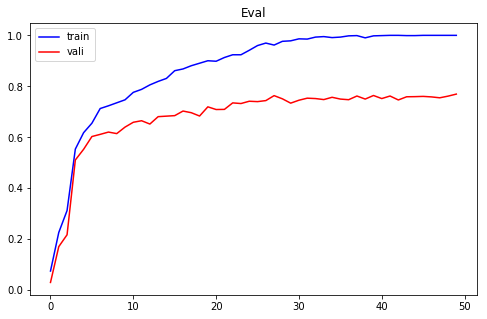

In [2]:
import matplotlib.pyplot as plt

xx = list(range(len(train_Eval)))

plt.figure(figsize = (8,5))
plt.plot(xx,train_Eval, color = 'blue', label = 'train')
plt.plot(xx,vali_Eval, color = 'red', label = 'vali')
plt.title('Eval')
plt.legend()
plt.show()

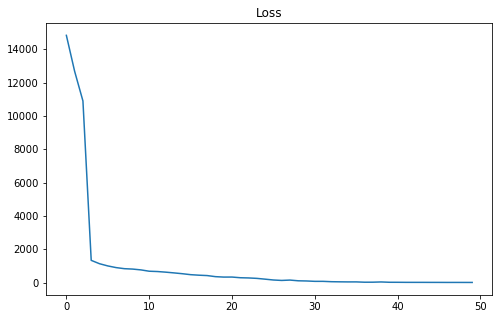

In [3]:
import matplotlib.pyplot as plt

xx = list(range(len(Loss)))

plt.figure(figsize = (8,5))
plt.plot(xx,Loss)
plt.title('Loss')
plt.show()

In [4]:
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.56      1.00      0.72        32
          1       0.67      0.74      0.71       131
          2       0.82      0.41      0.54       179
          3       0.69      0.89      0.78        53
          4       0.49      0.73      0.58        88
          5       0.74      0.66      0.70       205
          6       0.30      1.00      0.46         8
          7       0.92      0.56      0.70       230
          8       0.65      0.71      0.68        75
          9       0.37      0.78      0.50        58
         10       0.96      0.91      0.93       255
         11       0.41      0.98      0.57        47
         12       0.74      0.91      0.82        56
         13       0.92      0.63      0.75       226
         14       0.52      1.00      0.69        11
         15       0.67      1.00      0.80        40
         16       0.99      0.97      0.98       306

avg / total       0.81      0.75      0.76  

In [5]:
import h5py
filename = 'E:/Alibaba German AI Challenge/origin_DATA/round1_test_a_20181109.h5'
f = h5py.File(filename,'r')
test_s2 = f['sen2']

test = []
for i in range(0,test_s2.shape[0]):
    temp2 = test_s2[i].flatten()
    test.append(temp2)
test = np.array(test)

test_y = np.zeros((test.shape[0],17))

pred = tf.argmax(y_conv, 1)

test_x_0 = test[0:1500]
test_y_0 = test_y[0:1500]
P_0 = pred.eval(feed_dict={x:test_x_0, y_:test_y_0, keep_prob:1.0})

test_x_1 = test[1500:3000]
test_y_1 = test_y[1500:3000]
P_1 = pred.eval(feed_dict={x:test_x_1, y_:test_y_1, keep_prob:1.0})

test_x_2 = test[3000:4500]
test_y_2 = test_y[3000:4500]
P_2 = pred.eval(feed_dict={x:test_x_2, y_:test_y_2, keep_prob:1.0})

test_x_3 = test[4500:]
test_y_3 = test_y[4500:]
P_3 = pred.eval(feed_dict={x:test_x_3, y_:test_y_3, keep_prob:1.0})

P = np.hstack([P_0,P_1,P_2,P_3])

one_hot=tf.one_hot(P,17)
Pred_one_hot = sess.run(one_hot)
Pred_one_hot = Pred_one_hot.astype(np.int32)
out = pd.DataFrame(Pred_one_hot, columns = list(range(17)))
print(out.head())

outname = 'L2norm_1024_batchsize_4_conv_3_fc_Adam_relu_10signal.csv'
out.to_csv(outname, index = False, header = False)

   0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1
1   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
2   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0
3   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0
4   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0


* 使用shuffle全部数据作为训练集，在train.h5中随机抽取5k样本做validation
* batch_size:1024
* learning_rate:1e-4
* 优化函数：Adam
* 激活函数：relu
* 只使用s1的5、6通道和s2的10个信道
* 在损失函数中加入L2正则化项,正则化项系数设为1e-2

In [1]:
# start tensorflow interactiveSession                              
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random
import h5py

filename = 'E:/Alibaba German AI Challenge/data_process/data_shuffle.npy'
valiname = 'E:/Alibaba German AI Challenge/data_process/sample_of_training.npy'

data = np.load(filename)
vali = np.load(valiname)

train = np.hstack([data[:, 4096:6144],data[:, 8192:]])
vali = np.hstack([vali[:2000, 4096:6144],vali[:2000, 8192:]])

print('The shape of train is ',train.shape)
print('The shape of vali is ',vali.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 12288])
y_ = tf.placeholder("float", [None, 17])
keep_prob = tf.placeholder("float")
x_image = tf.reshape(x, [-1, 32, 32, 12])

# first convolutinal layer
w_conv1_1 = weight_variable([3, 3, 12, 64])
b_conv1_1 = bias_variable([64])

w_conv1_2 = weight_variable([3, 3, 64, 64])
b_conv1_2 = bias_variable([64])

h_conv1_1 = tf.nn.relu(conv2d(x_image, w_conv1_1) + b_conv1_1)
h_conv1_2 = tf.nn.relu(conv2d(h_conv1_1, w_conv1_2) + b_conv1_2)
h_pool1 = max_pool_2x2(h_conv1_2)

# second convolutional layer
w_conv2_1 = weight_variable([3, 3, 64, 128])
b_conv2_1 = bias_variable([128])

w_conv2_2 = weight_variable([3, 3, 128, 128])
b_conv2_2 = bias_variable([128])

h_conv2_1 = tf.nn.relu(conv2d(h_pool1, w_conv2_1) + b_conv2_1)
h_conv2_2 = tf.nn.relu(conv2d(h_conv2_1, w_conv2_2) + b_conv2_2)
h_pool2 = max_pool_2x2(h_conv2_2)

# flatten
h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*128])

# densely connected layer
w_fc1 = weight_variable([8*8*128, 2048])
b_fc1 = bias_variable([2048])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# fc_2
w_fc2 = weight_variable([2048, 2048])
b_fc2 = bias_variable([2048])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# dropout
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

# readout layer
w_fc3 = weight_variable([2048, 17])
b_fc3 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc2_drop, w_fc3) + b_fc3)

# train and evaluate the model
#交叉熵作为损失函数
gamma = 1e-2
delta = 1e-7
learning_rate = 1e-4
L2_norm = gamma*(tf.norm(w_fc3)+tf.norm(w_fc2)+tf.norm(w_fc1)+tf.norm(w_conv1_1)+tf.norm(w_conv1_2)+tf.norm(w_conv2_1)+tf.norm(w_conv2_2))
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))+ L2_norm
#cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []
vali_Eval = []
train_Eval = []

batch_size = 1024
step_num = 10000
for i in range(step_num):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})
    if i%200 == 0:
        temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        Loss.append(temp_loss)
        vali_Eval.append(vali_accuracy)
        train_Eval.append(train_accuracy)
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g" %(i, train_accuracy, vali_accuracy, temp_loss))



The shape of train is  (50989, 12305)
The shape of vali is  (2000, 12305)
step 0, train accuracy 0.0478516, vali accuracy 0.0245, train loss 15548.6
step 200, train accuracy 0.3125, vali accuracy 0.344, train loss 11199
step 400, train accuracy 0.337891, vali accuracy 0.366, train loss 10855.4
step 600, train accuracy 0.324219, vali accuracy 0.3795, train loss 11097.2
step 800, train accuracy 0.384766, vali accuracy 0.4005, train loss 9953.57
step 1000, train accuracy 0.422852, vali accuracy 0.436, train loss 9293.35
step 1200, train accuracy 0.394531, vali accuracy 0.4445, train loss 9676.55
step 1400, train accuracy 0.432617, vali accuracy 0.464, train loss 8971.15
step 1600, train accuracy 0.417969, vali accuracy 0.497, train loss 7222.17
step 1800, train accuracy 0.53418, vali accuracy 0.515, train loss 1679.48
step 2000, train accuracy 0.526367, vali accuracy 0.505, train loss 1627.26
step 2200, train accuracy 0.554688, vali accuracy 0.516, train loss 1423.45
step 2400, train accu

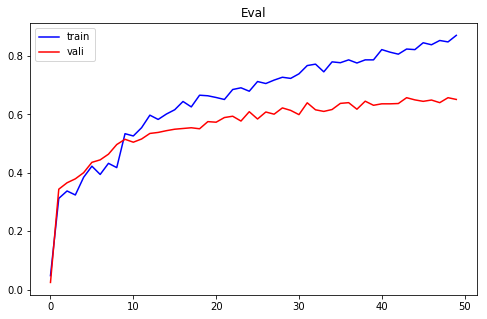

In [2]:
import matplotlib.pyplot as plt

xx = list(range(len(train_Eval)))

plt.figure(figsize = (8,5))
plt.plot(xx,train_Eval, color = 'blue', label = 'train')
plt.plot(xx,vali_Eval, color = 'red', label = 'vali')
plt.title('Eval')
plt.legend()
plt.show()

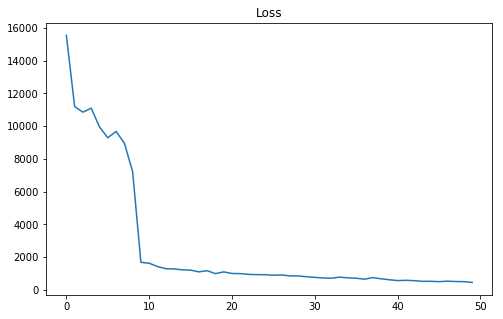

In [3]:
import matplotlib.pyplot as plt

xx = list(range(len(Loss)))

plt.figure(figsize = (8,5))
plt.plot(xx,Loss)
plt.title('Loss')
plt.show()

In [4]:
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.51      0.66      0.58        32
          1       0.61      0.56      0.58       131
          2       0.68      0.42      0.52       179
          3       0.48      0.64      0.55        53
          4       0.33      0.73      0.46        88
          5       0.65      0.41      0.51       205
          6       0.32      0.88      0.47         8
          7       0.89      0.51      0.65       230
          8       0.50      0.72      0.59        75
          9       0.33      0.67      0.44        58
         10       0.97      0.87      0.92       255
         11       0.31      0.89      0.46        47
         12       0.69      0.68      0.68        56
         13       0.83      0.54      0.66       226
         14       0.52      1.00      0.69        11
         15       0.56      0.97      0.71        40
         16       0.99      0.96      0.97       306

avg / total       0.74      0.67      0.68  

* 使用归一化的shuffe数据
* batch_size:1024
* learning_rate:1e-4
* 优化函数：Adam
* 激活函数：relu
* 只使用s2的10个信道
* 在损失函数中加入L2正则化项,正则化项系数设为1e-2

In [1]:
# start tensorflow interactiveSession                              
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random
import h5py

filename = 'E:/Alibaba German AI Challenge/data_process/data_shuffle_scaled.npy'

data = np.load(filename)

train = data[:49000, 8192:]
vali = data[49000:, 8192:]

print('The shape of train is ',train.shape)
print('The shape of vali is ',vali.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 10240])
y_ = tf.placeholder("float", [None, 17])
keep_prob = tf.placeholder("float")
x_image = tf.reshape(x, [-1, 32, 32, 10])

# first convolutinal layer
w_conv1_1 = weight_variable([3, 3, 10, 64])
b_conv1_1 = bias_variable([64])

w_conv1_2 = weight_variable([3, 3, 64, 64])
b_conv1_2 = bias_variable([64])

h_conv1_1 = tf.nn.relu(conv2d(x_image, w_conv1_1) + b_conv1_1)
h_conv1_2 = tf.nn.relu(conv2d(h_conv1_1, w_conv1_2) + b_conv1_2)
h_pool1 = max_pool_2x2(h_conv1_2)

# second convolutional layer
w_conv2_1 = weight_variable([3, 3, 64, 128])
b_conv2_1 = bias_variable([128])

w_conv2_2 = weight_variable([3, 3, 128, 128])
b_conv2_2 = bias_variable([128])

h_conv2_1 = tf.nn.relu(conv2d(h_pool1, w_conv2_1) + b_conv2_1)
h_conv2_2 = tf.nn.relu(conv2d(h_conv2_1, w_conv2_2) + b_conv2_2)
h_pool2 = max_pool_2x2(h_conv2_2)

# flatten
h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*128])

# densely connected layer
w_fc1 = weight_variable([8*8*128, 2048])
b_fc1 = bias_variable([2048])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# fc_2
w_fc2 = weight_variable([2048, 2048])
b_fc2 = bias_variable([2048])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# dropout
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

# readout layer
w_fc3 = weight_variable([2048, 17])
b_fc3 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc2_drop, w_fc3) + b_fc3)

# train and evaluate the model
#交叉熵作为损失函数
gamma = 1e-2
delta = 1e-7
learning_rate = 1e-4
L2_norm = gamma*(tf.norm(w_fc3)+tf.norm(w_fc2)+tf.norm(w_fc1)+tf.norm(w_conv1_1)+tf.norm(w_conv1_2)+tf.norm(w_conv2_1)+tf.norm(w_conv2_2))
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))+ L2_norm
#cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []
vali_Eval = []
train_Eval = []

batch_size = 1024
step_num = 10000
for i in range(step_num):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})
    if i%200 == 0:
        temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        Loss.append(temp_loss)
        vali_Eval.append(vali_accuracy)
        train_Eval.append(train_accuracy)
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g" %(i, train_accuracy, vali_accuracy, temp_loss))



The shape of train is  (49000, 10257)
The shape of vali is  (1989, 10257)
step 0, train accuracy 0.0673828, vali accuracy 0.0693816, train loss 15399.2
step 200, train accuracy 0.193359, vali accuracy 0.182504, train loss 13152.7
step 400, train accuracy 0.492188, vali accuracy 0.457014, train loss 1579.2
step 600, train accuracy 0.587891, vali accuracy 0.56913, train loss 1232.41
step 800, train accuracy 0.649414, vali accuracy 0.618401, train loss 1073.33
step 1000, train accuracy 0.699219, vali accuracy 0.633484, train loss 932.075
step 1200, train accuracy 0.679688, vali accuracy 0.646556, train loss 938.368
step 1400, train accuracy 0.716797, vali accuracy 0.667169, train loss 855.988
step 1600, train accuracy 0.722656, vali accuracy 0.678733, train loss 833.95
step 1800, train accuracy 0.78418, vali accuracy 0.702866, train loss 675.85
step 2000, train accuracy 0.777344, vali accuracy 0.703369, train loss 663.241
step 2200, train accuracy 0.731445, vali accuracy 0.694822, train l

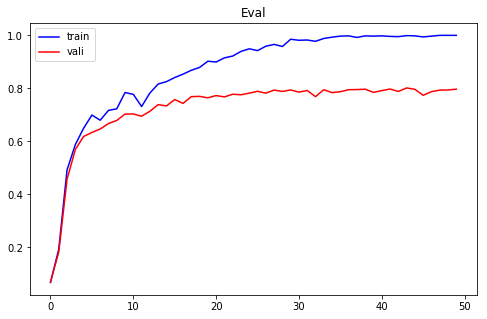

In [2]:
import matplotlib.pyplot as plt

xx = list(range(len(train_Eval)))

plt.figure(figsize = (8,5))
plt.plot(xx,train_Eval, color = 'blue', label = 'train')
plt.plot(xx,vali_Eval, color = 'red', label = 'vali')
plt.title('Eval')
plt.legend()
plt.show()

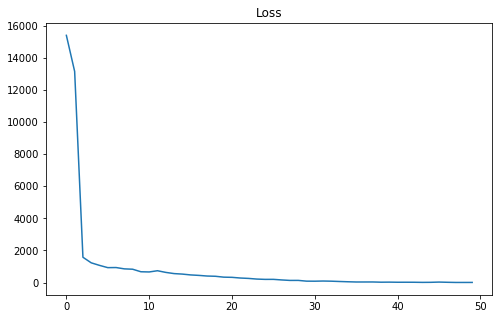

In [3]:
import matplotlib.pyplot as plt

xx = list(range(len(Loss)))

plt.figure(figsize = (8,5))
plt.plot(xx,Loss)
plt.title('Loss')
plt.show()

In [4]:
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.71      0.74      0.73       115
          1       0.69      0.65      0.67       107
          2       0.73      0.76      0.74       130
          3       0.74      0.61      0.67       118
          4       0.56      0.60      0.58       141
          5       0.67      0.79      0.72       122
          6       0.90      0.93      0.91       121
          7       0.78      0.79      0.78       136
          8       0.87      0.83      0.85       117
          9       0.66      0.55      0.60        97
         10       0.91      0.92      0.91       108
         11       0.76      0.87      0.81       100
         12       0.88      0.88      0.88       112
         13       0.94      0.82      0.88       114
         14       0.90      0.96      0.93       107
         15       0.94      0.90      0.92       138
         16       1.00      1.00      1.00       106

avg / total       0.80      0.80      0.80  